In [1]:
# 11/5 Get Raw Player Bios
# Cameron Yick

# For data manipulation
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
PROJ_ROOT = os.pardir

# For Scraping
from bs4 import BeautifulSoup
import requests
import time

# For munging
import re
import json

# Backoff time for large scrapes
THROTTLE_TIME = .05

# ipython magics
# %load_ext watermark
%matplotlib inline
# a nice bonus for making progress bars in ipython

from tqdm import tqdm, tqdm_pandas, tqdm_notebook


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Initialize reused objects
tqdm.pandas()
s= requests.Session()
s.headers.update({'User-agent': 'Mozilla/5.0'})


In [3]:
# playerPath = os.path.join(PROJ_ROOT, "data", "interim", "players.json")

In [4]:
# use with temp auth token

In [5]:
ghPath = "https://raw.githubusercontent.com/hydrosquall/yale_athletics_data/master/data/interim/harvard_players.json?token=AImmM-Q_QprW_hYT6_KwnNcP21It4pS7ks5YPkJ2wA%3D%3D"

In [6]:
# use online read path for usage with a distributed crawler
df = pd.read_json(ghPath)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10896 entries, 0 to 9999
Data columns (total 17 columns):
B/T            488 non-null object
City           10896 non-null object
Event          1418 non-null object
High School    10896 non-null object
Hometown       10896 non-null object
Ht.            5445 non-null object
Name           10896 non-null object
Name_link      10896 non-null object
No.            6265 non-null object
Position       6490 non-null object
Region         10896 non-null object
S/C            580 non-null object
Weapon         243 non-null object
Wt.            4251 non-null object
Yr.            10896 non-null object
season         10896 non-null object
sport          10896 non-null object
dtypes: object(17)
memory usage: 1.5+ MB


In [8]:
# There is are 10806 unique bio links... hm. Scrape now, clean later.
df['Name_link'].unique().shape

(10806,)

In [9]:
df.duplicated(subset=['Name_link'],keep=False).sum()

180

In [10]:
# how did this guy show up twice?!
df[df['Name_link'] == "/sports/bsb/2008-09/bios/albright_tyler"]

,B/T,City,Event,High School,Hometown,Ht.,Name,Name_link,No.,Position,Region,S/C,Weapon,Wt.,Yr.,season,sport
0,R/R,Long Beach,None,Woodrow Wilson,"Long Beach, Calif.",6-2,Tyler Albright,/sports/bsb/2008-09/bios/albright_tyler,6,C,Calif.,None,None,190,Jr.,2008-09,bsb
122,R/R,Long Beach,None,Woodrow Wilson,"Long Beach, Calif.",6-2,Tyler Albright,/sports/bsb/2008-09/bios/albright_tyler,6,C,Calif.,None,None,190,Jr.,2009-10,bsb


In [11]:
df[df.duplicated(subset=['Name_link'],keep=False)].head()

,B/T,City,Event,High School,Hometown,Ht.,Name,Name_link,No.,Position,Region,S/C,Weapon,Wt.,Yr.,season,sport
0,R/R,Long Beach,None,Woodrow Wilson,"Long Beach, Calif.",6-2,Tyler Albright,/sports/bsb/2008-09/bios/albright_tyler,6,C,Calif.,None,None,190,Jr.,2008-09,bsb
1,R/R,Austin,None,St. Stephens Episcopal,"Austin, Texas",5-10,Cole Arledge,/sports/bsb/2008-09/bios/arledge_cole,8,C,Texas,None,None,180,Jr.,2008-09,bsb
10,S/R,Winnetka,None,New Trier,"Winnetka, Ill.",6-3,Zach Hofeld,/sports/bsb/2008-09/bios/hofeld_zach,29,RHP,Ill.,None,None,205,Jr.,2008-09,bsb
10059,L/L,Carlsbad,None,La Costa Canyon,"Carlsbad, Calif.",None,Jackie Cooley,/sports/sball/2010-11/bios/cooley_jackie,9,Outfield,Calif.,None,None,None,Freshman,2010-11,sball
10227,None,Castle Rock,Diving,Rock Canyon,"Castle Rock, Colo.",None,Tanille Paniogue,/sports/wswimdive/2008-09/bios/paniogue_tanille,None,None,Colo.,None,None,None,Senior,2008-09,wswimdive


In [12]:
df['Name_link'].head()

0        /sports/bsb/2008-09/bios/albright_tyler
1          /sports/bsb/2008-09/bios/arledge_cole
10          /sports/bsb/2008-09/bios/hofeld_zach
100     /sports/bsb/2016-17/bios/allen_jake_gyf5
1000        /sports/mbkb/1984-85/Bios/Eric_Wanta
Name: Name_link, dtype: object

In [13]:
# Let's make some data soup!

def makeAthleteSoup(link, session=s):
    if not link:
        return None
    time.sleep(THROTTLE_TIME)
    result = session.get("http://www.gocrimson.com" + link)
    if result.status_code is 200:
        return BeautifulSoup(result.content, 'lxml').find('div', class_="bio-wrap")
    else:
        print("Site is down!")

In [14]:
bios = df['Name_link'].unique()

In [22]:
df['Name_link'].head()

0        /sports/bsb/2008-09/bios/albright_tyler
1          /sports/bsb/2008-09/bios/arledge_cole
10          /sports/bsb/2008-09/bios/hofeld_zach
100     /sports/bsb/2016-17/bios/allen_jake_gyf5
1000        /sports/mbkb/1984-85/Bios/Eric_Wanta
Name: Name_link, dtype: object

In [15]:
bios = pd.Series(bios)

## Main Loop

Download all the bios, contained within bio-wrapper!

Use tmux and run `ipython notebook &` as a background process to make sure it doesn't get stuck

In [16]:
soups = bios.progress_apply(lambda x: makeAthleteSoup(x))

100%|██████████| 10806/10806 [3:03:44<00:00,  1.20s/it]


In [21]:
# the join key is the bio URL
soups.index = bios
soups.head()

/sports/bsb/2008-09/bios/albright_tyler     <div class="bio-wrap clearfix" data-module="st...
/sports/bsb/2008-09/bios/arledge_cole       <div class="bio-wrap clearfix" data-module="st...
/sports/bsb/2008-09/bios/hofeld_zach        <div class="bio-wrap clearfix" data-module="st...
/sports/bsb/2016-17/bios/allen_jake_gyf5    <div class="bio-wrap bio-wrap-has-highlights c...
/sports/mbkb/1984-85/Bios/Eric_Wanta        <div class="bio-wrap clearfix" data-module="st...
dtype: object

Because of python 2.7 limitations, you cannot utf-8 encode and gzip simulateously. Thus we must use the linux gzip to do our compression.

In [24]:
pd.DataFrame(soups).to_csv('harvard_bios.csv', encoding="utf-8")

In [25]:
!du harvard_bios.csv

136216	harvard_bios.csv


In [30]:
!gzip -c harvard_bios.csv > harvard_bios.csv.gz

In [31]:
!du harvard_bios.csv.gz

11344	harvard_bios.csv.gz


In [32]:
d = pd.read_csv('harvard_bios.csv.gz', compression='gzip')

In [33]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10806 entries, 0 to 10805
Data columns (total 2 columns):
Unnamed: 0    10806 non-null object
0             10774 non-null object
dtypes: object(2)
memory usage: 168.9+ KB


In [41]:
type(d['0'].iloc[4])

str

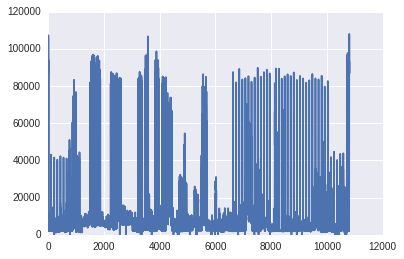

In [44]:
# check the lengths of these bio fields
test = d['0'].apply(lambda x: len(x) if (type(x) == str) else 0)
plt.plot(test)